# Detección de Anomalías para Detección de Fraudes

## Introducción

Un `outlier` es un dato que se encuentra muy alejado del resto de los datos que conforman la `mediana`, lo cual puede ocasionar valores atípicos al momento de analizar los datos. Esto puede ser debido a un error en la captura de la información, o al momento de realizar la medición, sin embargo, también puede ocurrir naturalmente.

### Detección de Anomalías
La detección de anomalías es un proceso o método para identificar datos, eventos o comportamientos inesperados. Es un área bien establecida dentro de la ciencia de datos y existe una gran cantidad de algoritmos para detectar anomalías en un conjunto de datos según el tipo de datos y su contexto.





## Conjunto de Datos

El siguiente conjunto de Datos fue proporcionado por [Kaggle](https://www.kaggle.com). Los datos sirven para la [Detección de Billetes Falsificados Suizos](https://www.kaggle.com/chrizzles/swiss-banknote-conterfeit-detection), los cuales presentan información como la forma del billete y si son falsificados o no. El conjunto de datos muestra 200 billetes, donde 100 son genuinos y 100 son falsos.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [53]:
path = 'drive/MyDrive/Colab Notebooks/AnomalyDetection/banknotes.csv'

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import chi2
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import MinCovDet
from sklearn.cluster import DBSCAN

Los datos de las columnas son:
* conterfeit: Si el billete es falso (1) o real (0)
* Length: Longitud del billete (mm)
* Left: Ancho del borde izquierdo (mm)
* Right: Ancho del borde derecho (mm)
* Bottom: Ancho del margen del fondo (mm)
* Top: Ancho del margen de arriba (mm)
* Diagonal: Longitud de la diagonal (mm)

In [55]:
df_raw = pd.read_csv(path)
df_raw.head()

,conterfeit,Length,Left,Right,Bottom,Top,Diagonal
0,0,214.8,131.0,131.1,9.0,9.7,141.0
1,0,214.6,129.7,129.7,8.1,9.5,141.7
2,0,214.8,129.7,129.7,8.7,9.6,142.2
3,0,214.8,129.7,129.6,7.5,10.4,142.0
4,0,215.0,129.6,129.7,10.4,7.7,141.8


In [6]:
# Quitamos la columna de si es falso o no para luego evaluar el método
df = df_raw.drop('conterfeit',axis=1)
df.head()

,Length,Left,Right,Bottom,Top,Diagonal
0,214.8,131.0,131.1,9.0,9.7,141.0
1,214.6,129.7,129.7,8.1,9.5,141.7
2,214.8,129.7,129.7,8.7,9.6,142.2
3,214.8,129.7,129.6,7.5,10.4,142.0
4,215.0,129.6,129.7,10.4,7.7,141.8


In [7]:
df_copy = df.copy()

### Análisis Exploratorio de Datos

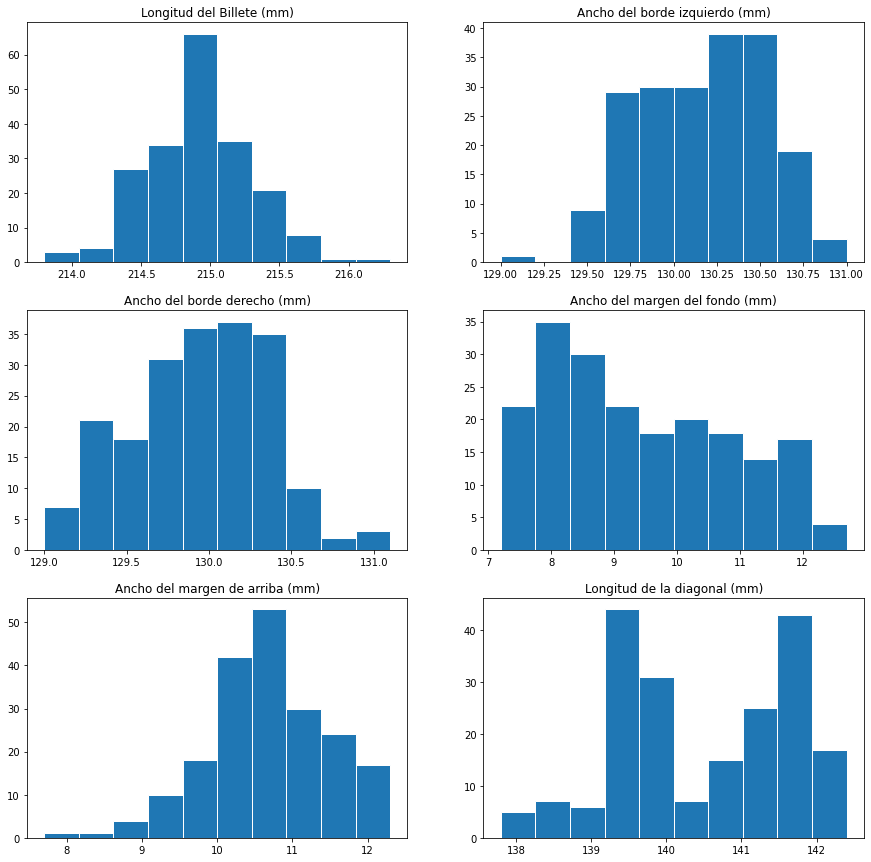

In [8]:
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(15,15)

ax[0,0].hist(df['Length'],edgecolor='white')
ax[0,0].set_title('Longitud del Billete (mm)')

ax[0,1].hist(df['Left'],edgecolor='white')
ax[0,1].set_title('Ancho del borde izquierdo (mm)')

ax[1,0].hist(df['Right'],edgecolor='white')
ax[1,0].set_title('Ancho del borde derecho (mm)')

ax[1,1].hist(df['Bottom'],edgecolor='white')
ax[1,1].set_title('Ancho del margen del fondo (mm)')

ax[2,0].hist(df['Top'],edgecolor='white')
ax[2,0].set_title('Ancho del margen de arriba (mm)')

ax[2,1].hist(df['Diagonal'],edgecolor='white')
ax[2,1].set_title('Longitud de la diagonal (mm)')
plt.show()

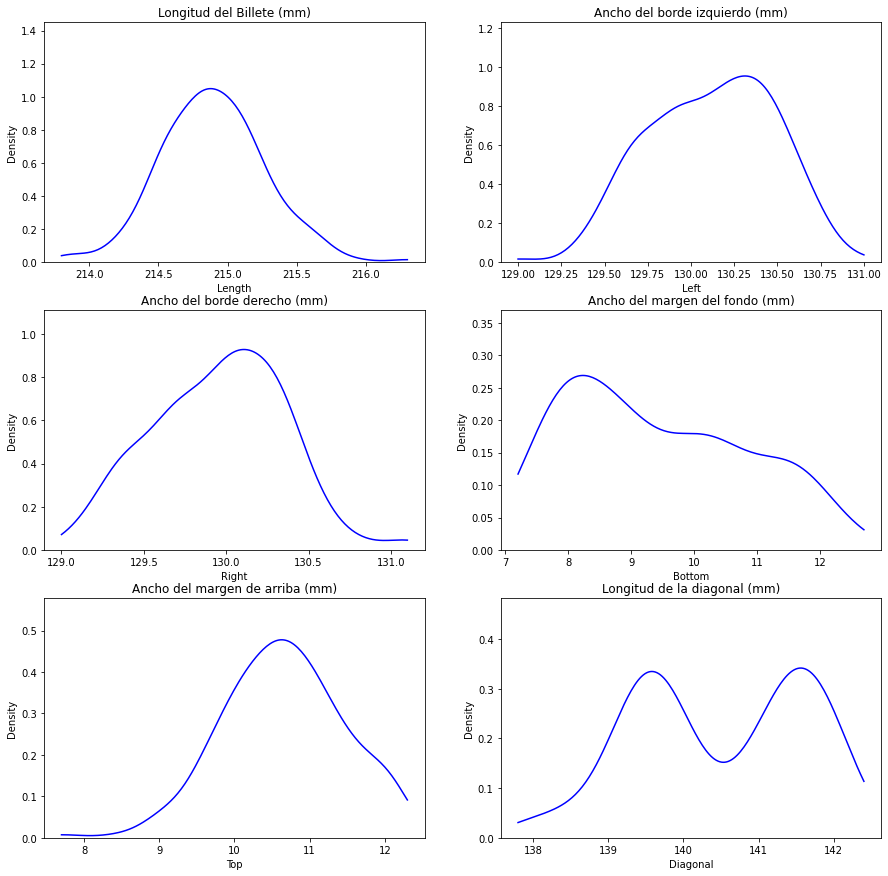

In [9]:
# Gráfica de Densidad
fig, ax = plt.subplots(3, 2)
fig.set_size_inches(15,15)

sns.histplot(df['Length'],ax=ax[0][0],color='b',kde=True,stat='density',shrink=0)
ax[0,0].set_title('Longitud del Billete (mm)')

sns.histplot(df['Left'],ax=ax[0][1],color='b',kde=True,stat='density',shrink=0)
ax[0,1].set_title('Ancho del borde izquierdo (mm)')

sns.histplot(df['Right'],ax=ax[1][0],color='b',kde=True,stat='density',shrink=0)
ax[1,0].set_title('Ancho del borde derecho (mm)')

sns.histplot(df['Bottom'],ax=ax[1][1],color='b',kde=True,stat='density',shrink=0)
ax[1,1].set_title('Ancho del margen del fondo (mm)')

sns.histplot(df['Top'],ax=ax[2][0],color='b',kde=True,stat='density',shrink=0)
ax[2,0].set_title('Ancho del margen de arriba (mm)')

sns.histplot(df['Diagonal'],ax=ax[2][1],color='b',kde=True,stat='density',shrink=0)
ax[2,1].set_title('Longitud de la diagonal (mm)')
plt.show()

Si bien, la mayoría de las gráficas parecen tener una distribución normal, se ve claramente que la columna `Bottom` y la columna `Diagonal` parecen tener otro tipo de distribución.

Ahora veamos un mapa de correlación:

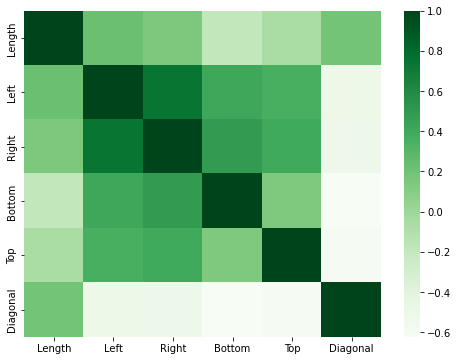

In [59]:
 fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(df_copy.corr(),cmap="Greens")
plt.show()

La mayor correlación que existe es entre "Left" y "Right", lo cual tiene sentido ya que deben de estar masomenos iguales de tamaño ambas mediciones. También vemos que la "Diagonal" tiene correlación negativa con todos, menos con la columna "Length"

## Métodos para la Detección de Anomalías

### Z-Score

Z-Score es el número con signo de desviaciones estándar por las cuales el valor de una observación o un punto de datos está por encima del valor medio de lo que se está observando o midiendo. 
Usando el método de Z-Score, podemos averiguar cuántas desviaciones estándar se alejan de la media.

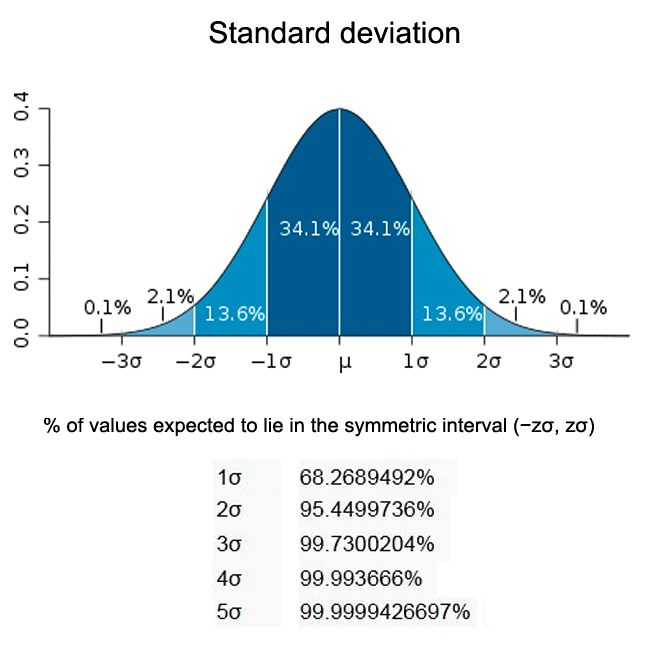

Esta técnica asume una distribución gaussiana de los datos. Los valores atípicos son los puntos de datos que se encuentran en las colas de la distribución y, por lo tanto, lejos de la media.
* El 68% de los puntos de datos se encuentran entre + o - 1 desviación estándar.
* 95% de los puntos de datos se encuentran entre + o - 2 desviación estándar
* El 99,7% de los puntos de datos se encuentran entre + o - 3 desviaciones estándar

Formula Z-Score: 
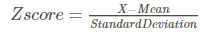

Si el z-score de un punto de datos es más de 3 (porque cubre el 99,7% del área), indica que el valor de los datos es bastante diferente de los otros valores y se toma como un outlier.

In [10]:
df['ZScore'] = np.zeros(200)

In [11]:
def Zscore_outlier(col):
    out = []
    i = 0
    m = np.mean(col)
    sd = np.std(col)
    for val in col: 
        z = (val-m)/sd
        if np.abs(z) > 3: 
            out.append(val)
            df['ZScore'][i] = 1
        i+=1
           
    print("Outliers:",out)
        

In [12]:
Zscore_outlier(df['Length'])
Zscore_outlier(df['Left'])
Zscore_outlier(df['Right'])
Zscore_outlier(df['Bottom'])
Zscore_outlier(df['Top'])
Zscore_outlier(df['Diagonal'])

Outliers: [216.3]
Outliers: [129.0]
Outliers: []
Outliers: []
Outliers: [7.7]
Outliers: []


In [13]:
results = df_raw.copy()

In [14]:
print("Accuracy: "+str(accuracy_score(results["conterfeit"],df["ZScore"])))
conf_matrix = confusion_matrix(results["conterfeit"],df["ZScore"])
print(conf_matrix)

Accuracy: 0.495
[[98  2]
 [99  1]]


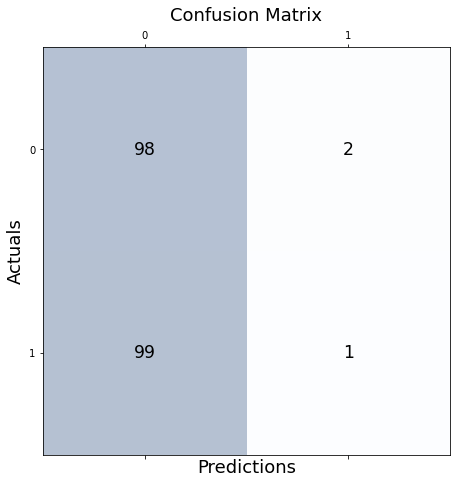

In [15]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

### Robust Z-Score

También se denomina método de desviación absoluta de la mediana. Es similar al método de Z-Score con algunos cambios en los parámetros. Dado que las desviaciones medias y estándar están muy influenciadas por valores atípicos, para modificar estos parámetros utilizamos la desviación media y absoluta de la mediana.


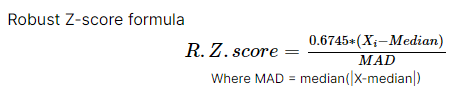

In [16]:
df['ZRScore'] = np.zeros(200)

In [17]:
def ZRscore_outlier(col):
    out = []
    i = 0
    med = np.median(col)
    ma = stats.median_absolute_deviation(col)
    for val in col: 
        z = (0.6745*(val-med))/ (np.median(ma))
        if np.abs(z) > 3: 
            out.append(val)
            df['ZRScore'][i] = 1
        i+=1
    print("Outliers:",out)


In [18]:
ZRscore_outlier(df['Length'])
ZRscore_outlier(df['Left'])
ZRscore_outlier(df['Right'])
ZRscore_outlier(df['Bottom'])
ZRscore_outlier(df['Top'])
ZRscore_outlier(df['Diagonal'])

Outliers: [216.3]
Outliers: []
Outliers: []
Outliers: []
Outliers: []
Outliers: []


In [19]:
print("Accuracy: "+str(accuracy_score(results["conterfeit"],df["ZRScore"])))
conf_matrix = confusion_matrix(results["conterfeit"],df["ZRScore"])
print(conf_matrix)

Accuracy: 0.505
[[100   0]
 [ 99   1]]


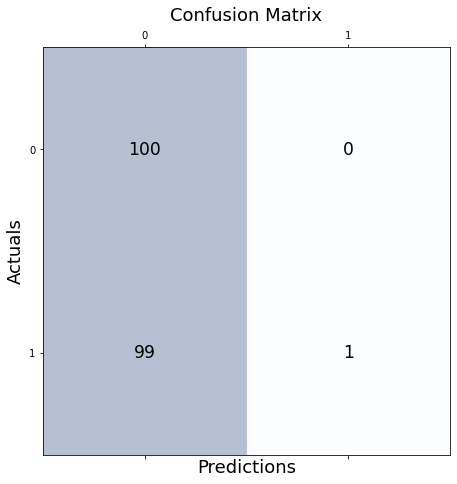

In [20]:
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

### IQR Method

Este método utiliza el rango intercuartil (IQR), donde se detectan los outliers. El IQR nos dice la variación que existe en un conjunto de datos. Un outlier se encuentra entre -1.5 x IQR y 1.5 x IQR

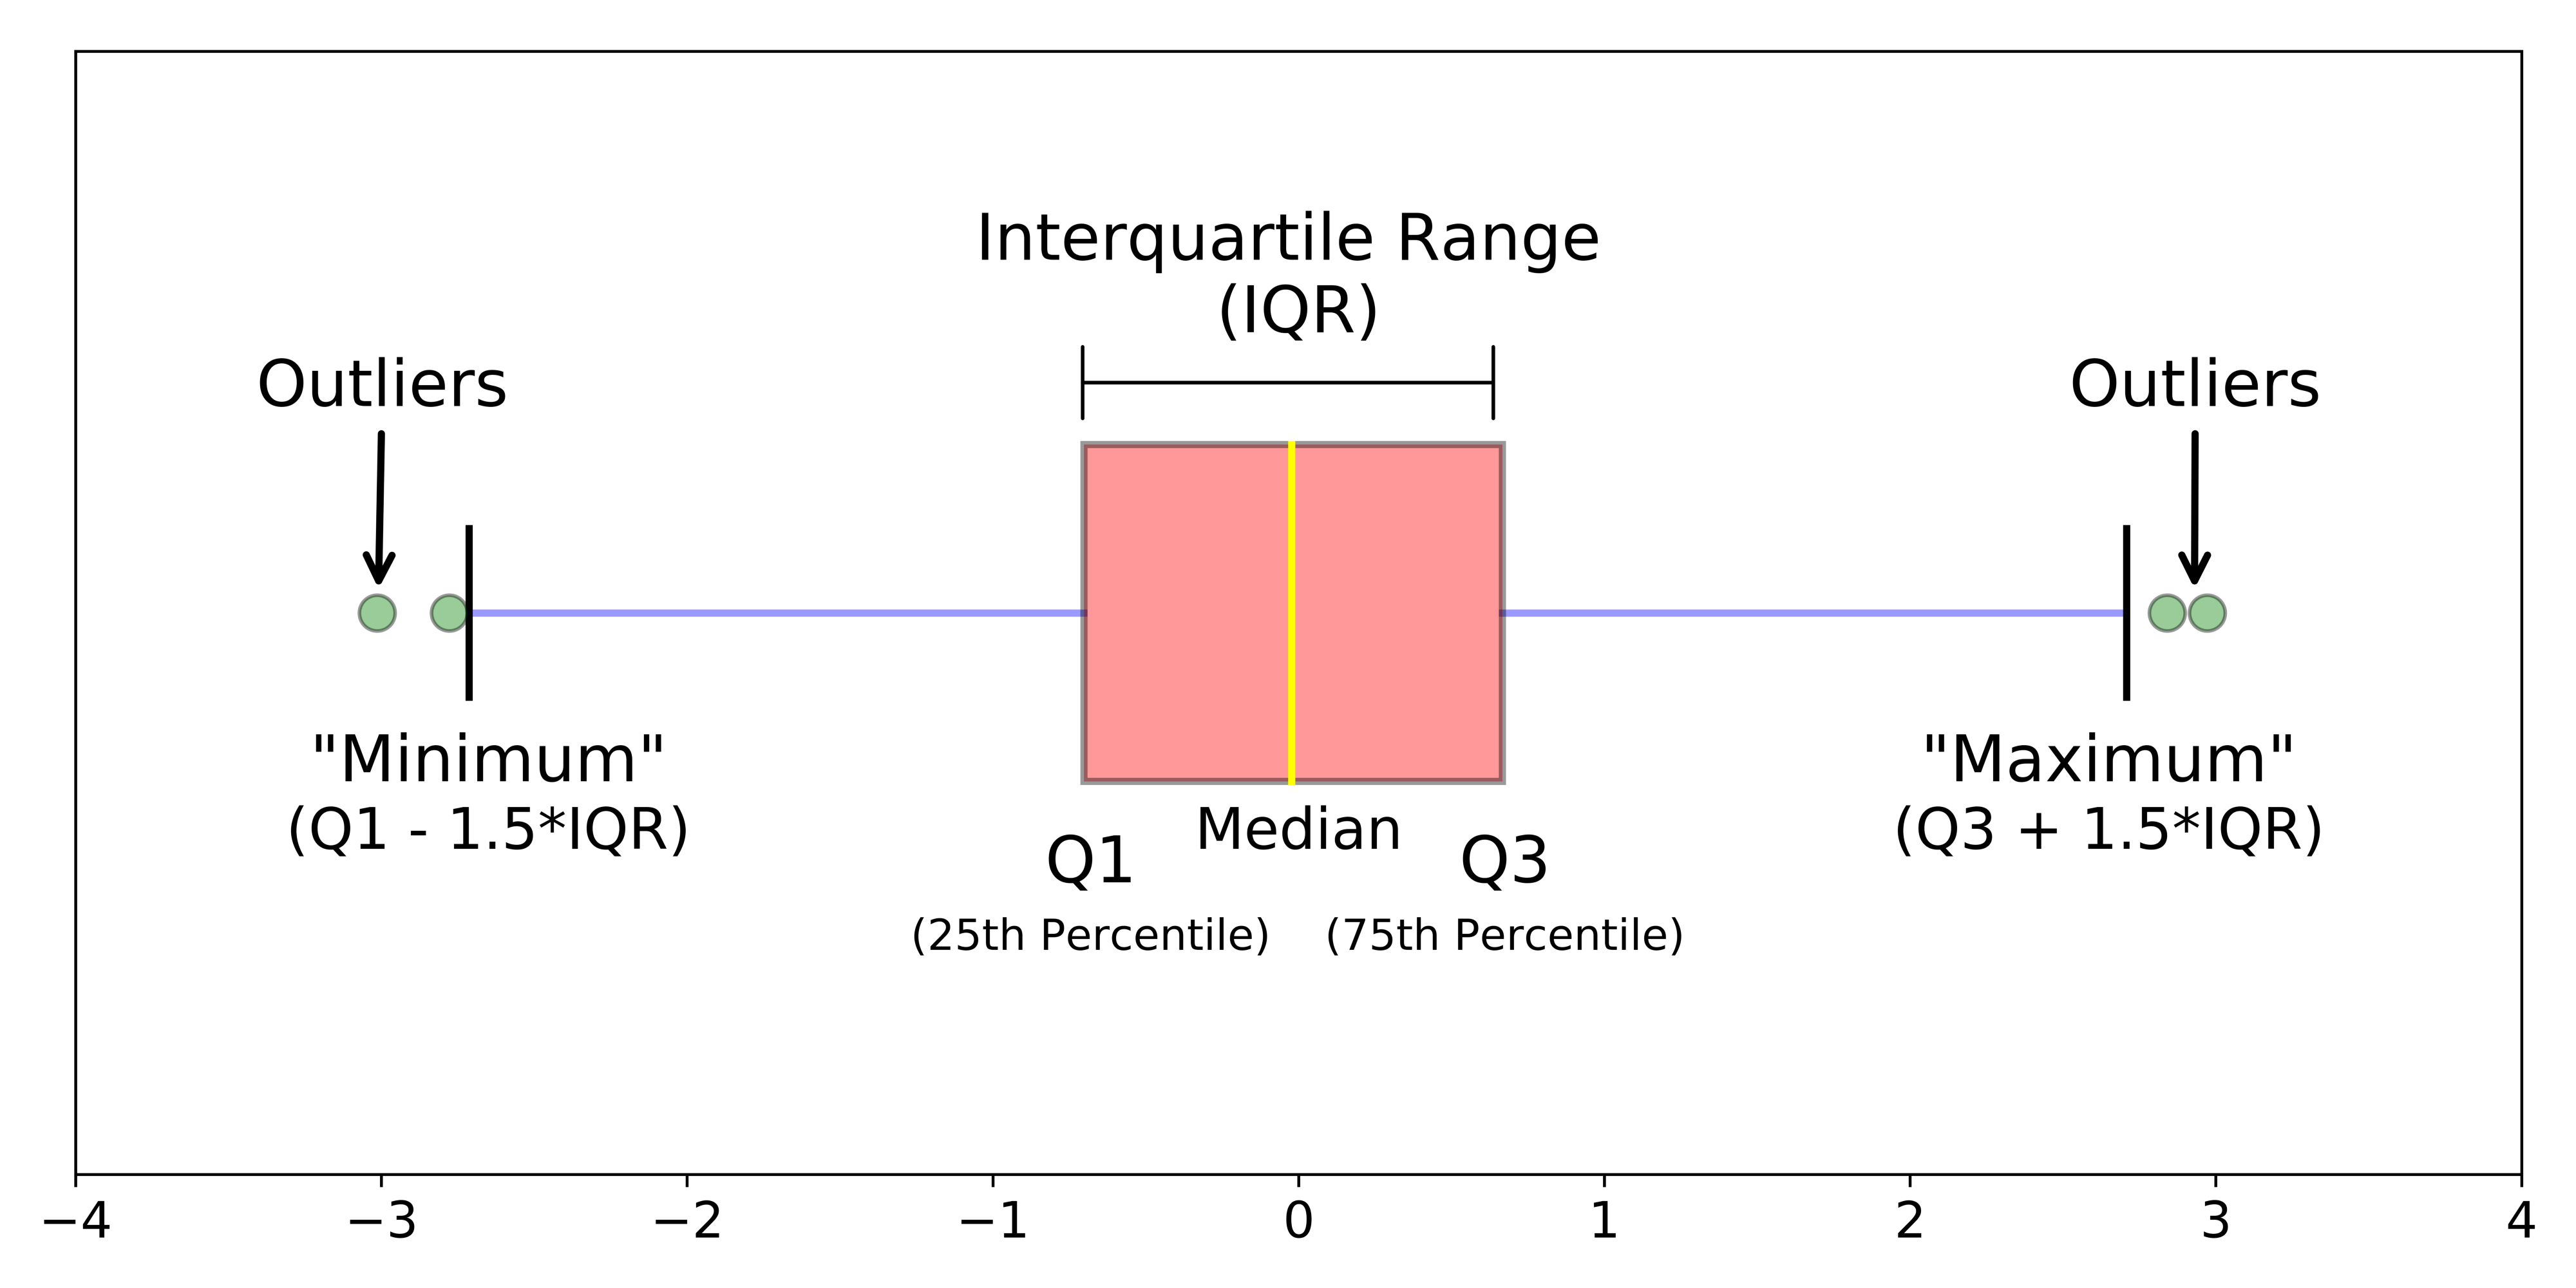

In [21]:
df['IQR'] = np.zeros(200)

In [22]:
def iqr_outliers(col):
    out=[]
    i = 0
    q1 = col.quantile(0.25)
    q3 = col.quantile(0.75)
    iqr = q3-q1
    Lower_tail = q1 - 1.5 * iqr
    Upper_tail = q3 + 1.5 * iqr
    for val in col:
        if val > Upper_tail or val < Lower_tail:
            out.append(val)
            df['IQR'][i] = 1
        i+=1
    print("Outliers:",out)


In [23]:
iqr_outliers(df['Length'])
iqr_outliers(df['Left'])
iqr_outliers(df['Right'])
iqr_outliers(df['Bottom'])
iqr_outliers(df['Top'])
iqr_outliers(df['Diagonal'])

Outliers: [215.9, 213.8, 216.3]
Outliers: [129.0]
Outliers: [131.1, 131.1, 131.1]
Outliers: []
Outliers: [7.7]
Outliers: []


In [24]:
print("Accuracy: "+str(accuracy_score(results["conterfeit"],df["IQR"])))
conf_matrix = confusion_matrix(results["conterfeit"],df["IQR"])
print(conf_matrix)

Accuracy: 0.49
[[95  5]
 [97  3]]


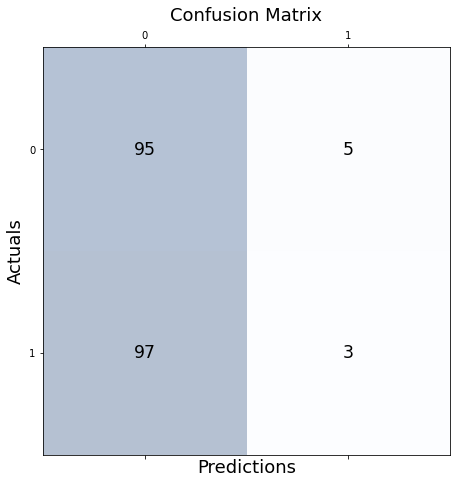

In [25]:
# Print the confusion matrix using Matplotlib

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

### Winsorization Method (Percentile Capping)

Este método es parecido al IQR, sólo que si un valor se encuentra por arriba del 99% percentil y por debajo de 1% percentil se considera un outlier

In [26]:
df['Winsorization'] = np.zeros(200)

In [27]:
def Winsorization_outliers(col):
    out =[]
    i = 0
    q1 = np.percentile(col , 1)
    q3 = np.percentile(col , 99)
    for val in col:
        if val > q3 or val < q1:
            out.append(val)
            df['Winsorization'][i] = 1
        i+=1
            
    print("Outliers:",out)

In [28]:
Winsorization_outliers(df['Length'])
Winsorization_outliers(df['Left'])
Winsorization_outliers(df['Right'])
Winsorization_outliers(df['Bottom'])
Winsorization_outliers(df['Top'])
Winsorization_outliers(df['Diagonal'])

Outliers: [215.9, 213.8, 216.3]
Outliers: [131.0, 129.0]
Outliers: [129.0]
Outliers: [12.5, 12.7]
Outliers: [7.7, 8.5, 12.3]
Outliers: [142.4, 137.8, 137.8]


In [29]:
print("Accuracy: "+str(accuracy_score(results["conterfeit"],df["Winsorization"])))
conf_matrix = confusion_matrix(results["conterfeit"],df["Winsorization"])
print(conf_matrix)

Accuracy: 0.49
[[92  8]
 [94  6]]


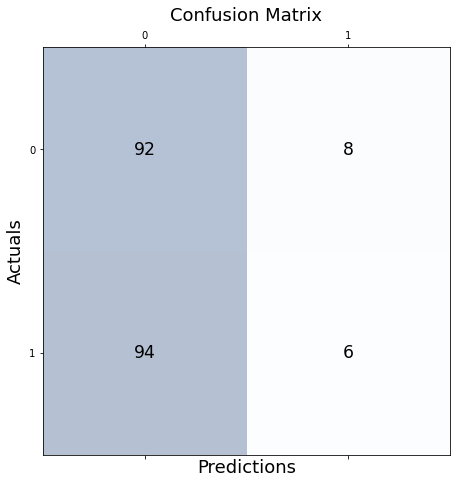

In [30]:
# Print the confusion matrix using Matplotlib

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

### Isolation Forest


Es un algoritmo de clustering que pertenece a la familia de árboles de decisión.
1. Clasifica los datos como outliers o como no outliers
2. Funciona basado en un árbol de decisión, donde separa y aísla a los outliers
3. Si el resultado es -1 significa que ese preciso dato es un outlier. Si es 1, ese dato no es outlier.

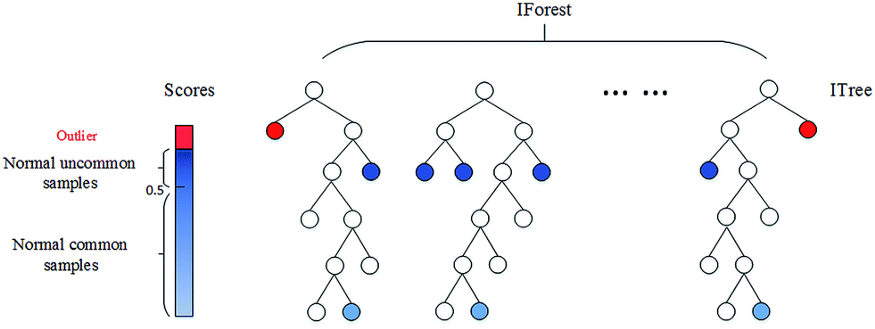

In [31]:
df_copy

,Length,Left,Right,Bottom,Top,Diagonal
0,214.8,131.0,131.1,9.0,9.7,141.0
1,214.6,129.7,129.7,8.1,9.5,141.7
2,214.8,129.7,129.7,8.7,9.6,142.2
3,214.8,129.7,129.6,7.5,10.4,142.0
4,215.0,129.6,129.7,10.4,7.7,141.8
...,...,...,...,...,...,...
195,215.0,130.4,130.3,9.9,12.1,139.6
196,215.1,130.3,129.9,10.3,11.5,139.7
197,214.8,130.3,130.4,10.6,11.1,140.0
198,214.7,130.7,130.8,11.2,11.2,139.4


In [32]:
isf=IsolationForest()
isf_outliers=isf.fit_predict(df_copy)

In [33]:
df['ISF'] = isf_outliers
df['ISF'] = df['ISF'].map({1:0,-1:1})
df.ISF.values

array([1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0])

In [34]:
print("Accuracy: "+str(accuracy_score(results["conterfeit"],df["ISF"])))
conf_matrix = confusion_matrix(results["conterfeit"],df["ISF"])
print(conf_matrix)

Accuracy: 0.52
[[89 11]
 [85 15]]


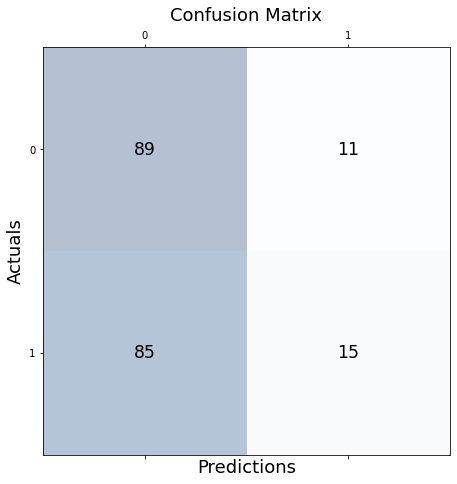

In [35]:
# Print the confusion matrix using Matplotlib

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

### Mahalanobis Distance

Estimación robusta de covarianza usando MCD y detección de valores outliers usando la medida de distancia de Mahalanobis

In [40]:
def get_mcd_outliers(data,threshold,type="outlier"):
    #MCD Estimators and Mahalanobis distances of data
    mcd_estimator=MinCovDet().fit(data)
    mahalanobis=mcd_estimator.mahalanobis(data)
    #Calculate outliers based on threshold
    if type=="outlier":
        transformation = lambda x: 0 if x <= threshold else 1
    elif type=="weights":
        transformation = lambda x: 1 if x <= threshold else 0
    outliers = np.array([transformation(xi) for xi in mahalanobis])
    return outliers

In [41]:
p=df.shape[1]
threshold = chi2.ppf(0.975, p)
mcd_outliers = get_mcd_outliers(df_copy,threshold)
df["MCD_Outlier"]=mcd_outliers

In [38]:
print("Accuracy: "+str(accuracy_score(results["conterfeit"],df["MCD_Outlier"])))
conf_matrix = confusion_matrix(results["conterfeit"],df["MCD_Outlier"])
print(conf_matrix)

Accuracy: 0.56
[[97  3]
 [85 15]]


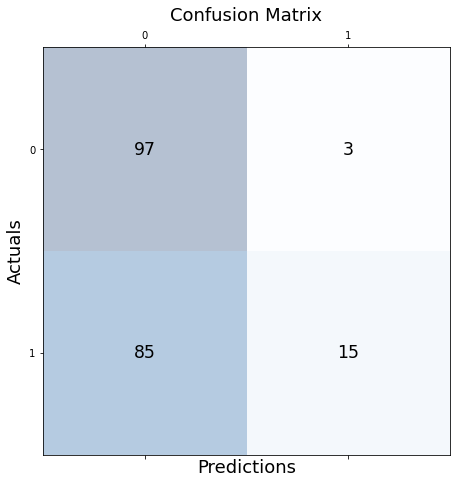

In [42]:
# Print the confusion matrix using Matplotlib

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

### Local Outlier Factor

LOF utiliza la detección de outliers basada en la densidad para identificar outliers locales, puntos que son valores atípicos con respecto a su vecindario local, en lugar de con respecto a la distribución global de datos. Cuanto mayor sea el valor de LOF para una observación, más anómala será la observación.


In [43]:
#Local Outlier Factor
lof=make_pipeline(StandardScaler(),LocalOutlierFactor())
lof_outliers=lof.fit_predict(df_copy)
df["LOF"]=lof_outliers
df["LOF"]=df["LOF"].map({1:0,-1:1})

In [44]:
print("Accuracy: "+str(accuracy_score(results["conterfeit"],df["LOF"])))
conf_matrix = confusion_matrix(results["conterfeit"],df["LOF"])
print(conf_matrix)

Accuracy: 0.51
[[97  3]
 [95  5]]


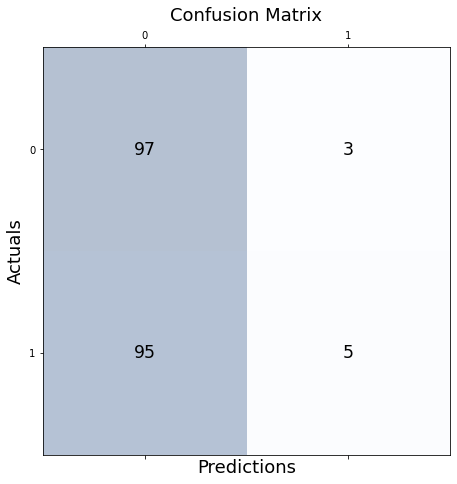

In [45]:
# Print the confusion matrix using Matplotlib

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

### DBSCAN

DBSCAN es un algoritmo de agrupación en clúster basado en densidad que divide un conjunto de datos en subgrupos de regiones de alta densidad e identifica el clúster de regiones de alta densidad como outliers. En este caso, el grupo -1 indica que el grupo contiene outliers y el resto de los grupos no tienen outliers.


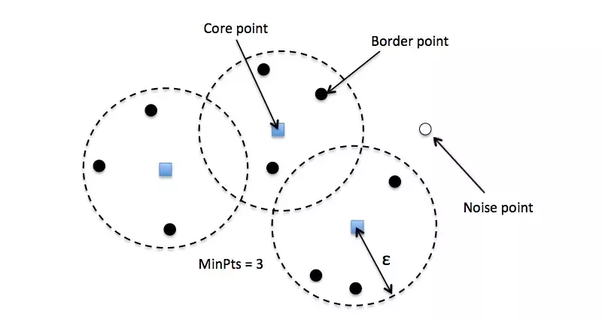

In [46]:
db = make_pipeline(StandardScaler(),DBSCAN(eps=3.0, min_samples=10))
db_outliers=db.fit_predict(df_copy)
df["DBSCAN"]=lof_outliers
df["DBSCAN"]=df["DBSCAN"].map({1:0,-1:1})

In [47]:
print("Accuracy: "+str(accuracy_score(results["conterfeit"],df["DBSCAN"])))
conf_matrix = confusion_matrix(results["conterfeit"],df["DBSCAN"])
print(conf_matrix)

Accuracy: 0.51
[[97  3]
 [95  5]]


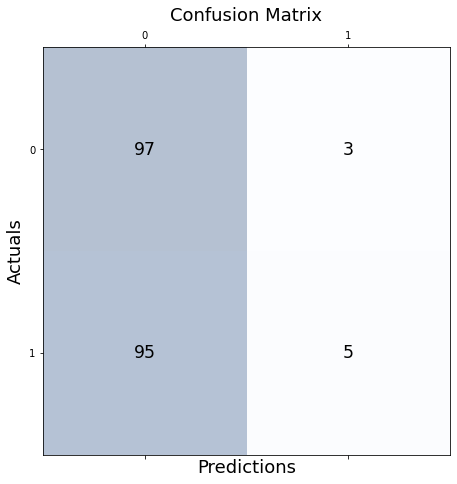

In [48]:
# Print the confusion matrix using Matplotlib

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

## Resultados

In [49]:
#Compare different methods
methods=["ZScore","ZRScore","IQR","Winsorization","ISF","MCD_Outlier","LOF"]
comparison=pd.DataFrame(columns=["TN","FP","FN","TP"])
for method in methods:
    comparison.loc[method]=confusion_matrix(results["conterfeit"],df[method]).reshape(4)
comparison["Accuracy"]=(comparison["TP"]+comparison["TN"])/len(df_copy)
comparison["Sensitivity"]=(comparison["TP"])/(len(df_copy)/2)
comparison["Specificity"]=(comparison["TN"])/(len(df_copy)/2)
comparison.sort_values(by="Sensitivity",inplace=True)
comparison

,TN,FP,FN,TP,Accuracy,Sensitivity,Specificity
ZScore,98,2,99,1,0.495,0.01,0.98
ZRScore,100,0,99,1,0.505,0.01,1
IQR,95,5,97,3,0.49,0.03,0.95
LOF,97,3,95,5,0.51,0.05,0.97
Winsorization,92,8,94,6,0.49,0.06,0.92
ISF,89,11,85,15,0.52,0.15,0.89
MCD_Outlier,98,2,85,15,0.565,0.15,0.98


In [60]:
import plotly.graph_objects as go
fig=go.Figure()
fig.add_trace(go.Bar(y=methods,x=comparison["TN"]/100,orientation="h",name="Billetes auténticos correctamente identificados (TNR) (%)"))
fig.add_trace(go.Bar(y=methods,x=comparison["TP"]/100,orientation="h",name="Billetes falsos correctamente identificados (TPR) (%)"))